### purpose 

visualize results across methods for multivariate nuis runs and compare to 0-nuisance runs for 6-trait runs

In [1]:
from pythonimports import *
from myfigs import adjust_box_widths, save_pdf

import MVP_summary_functions as mvp

import seaborn as sns
import itertools as it
plt.rcParams.update({'font.family' : 'serif'})

t0 = dt.now()  # notebook timer

outerdir = '/home/b.lind/offsets/run_20220919_nuisance/tutorial'
summary_dir = '/work/lotterhos/MVP-Offsets/run_20220919/summaries'
fig_dir = makedir(f'{summary_dir}/07_experiments/02_nuisance_envs/15_visualize_multivariate_nuis_results')

mvp.latest_commit()
session_info.show()

#########################################################
Today:	October 04, 2023 - 14:16:52 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 9493334506a1f2926fba0734fa74ba2f87194611  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jun 30 09:41:00 2023 -0400

Current commit of MVP_offsets:
commit 782ee79eada654ce337935bf61a0984cd76dd9cf  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Oct 4 14:13:12 2023 -0400
#########################################################



# Get scores

In [2]:
# get nuisance validation scores
program_dirs = fs(outerdir, exclude='pca')

program_dirs

['/home/b.lind/offsets/run_20220919_nuisance/tutorial/gradient_forests',
 '/home/b.lind/offsets/run_20220919_nuisance/tutorial/lfmm2',
 '/home/b.lind/offsets/run_20220919_nuisance/tutorial/rda']

In [3]:
validations = []
programs = []
for d in program_dirs:
    program = op.basename(d)
    df = pd.read_table(f'{d}/validation/tutorial_validation_scores.txt')
    if 'program' not in df.columns.tolist():
        print(program)
        df['program'] = program
    df['nuis_envs'] = '6-trait 3-nuisance'
        
    validations.append(df)
    
    programs.append(program)

In [4]:
# get non-nuisance validation scores
for program in programs:
    file = f'/home/b.lind/offsets/run_20220919_tutorial/{program}/validation/tutorial_validation_scores.txt'
    df = pd.read_table(file)
    if 'program' not in df.columns.tolist():
        print(program)
        df['program'] = program
    df['nuis_envs'] = '6-trait 0-nuisance'
    
    validations.append(df)

In [5]:
# combine nuisance and non-nuisance into a single dataframe
validation = pd.concat(validations).reset_index(drop=False)

validation

,index,seed,ind_or_pooled,marker_set,garden,score,program,nuis_envs,ntraits,structcorr
0,0,tutorial,pooled,adaptive,1,-0.839297,GF,6-trait 3-nuisance,NaN,NaN
1,1,tutorial,pooled,adaptive,2,-0.803961,GF,6-trait 3-nuisance,NaN,NaN
2,2,tutorial,pooled,adaptive,3,-0.831902,GF,6-trait 3-nuisance,NaN,NaN
3,3,tutorial,pooled,adaptive,4,-0.754900,GF,6-trait 3-nuisance,NaN,NaN
4,4,tutorial,pooled,adaptive,5,-0.739012,GF,6-trait 3-nuisance,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2795,795,tutorial,pooled,rda_outliers,96,-0.615214,rda-structcorr,6-trait 0-nuisance,ntraits-6,structcorr
2796,796,tutorial,pooled,rda_outliers,97,-0.573997,rda-structcorr,6-trait 0-nuisance,ntraits-6,structcorr
2797,797,tutorial,pooled,rda_outliers,98,-0.567906,rda-structcorr,6-trait 0-nuisance,ntraits-6,structcorr
2798,798,tutorial,pooled,rda_outliers,99,-0.622891,rda-structcorr,6-trait 0-nuisance,ntraits-6,structcorr


In [6]:
# leave in rda_outliers for now
validation.marker_set.unique()

array(['adaptive', 'all', 'neutral', 'rda_outliers'], dtype=object)

In [7]:
sum(validation.marker_set != 'rda_outliers')

2400

In [8]:
# number matches Fig 1D? A: yes!
validation[validation.marker_set != 'rda_outliers'].nuis_envs.value_counts()

6-trait 3-nuisance    1200
6-trait 0-nuisance    1200
Name: nuis_envs, dtype: int64

# visualize

In [9]:
# mvp.boxplot_kwargs['palette'].update({
#     '6-trait 0-nuisance' : '#157f3b',
#     '6-trait 3-nuisance' : '#006428'
# })

mvp.factor_names.update({
    '6-trait 0-nuisance' : '6-trait 0-nuisance',
    '6-trait 3-nuisance' : '6-trait 3-nuisance',
    '6-trait' : 'Nuisance\nLevel'
})

In [22]:
def cleanup_fig(g, xlabel="Landscape", loc='center left', bbox_to_anchor=None, color_by=None, fontsize=11,
                ncol=1, replace=None, figsize=(8, 4), one_trait=False, title=None):
    """Make the fig look rull pretty."""
    
    g.figure.set_size_inches(figsize)
    
    adjust_box_widths(list(g.axes[0]), 0.85)
    
    g.set(ylim=(0.65, -1),
          yticks=mvp.ytick_labels,
          yticklabels=mvp.ytick_labels)
    
    if title is not None:
        g.set(title=title)
    
    g.set_axis_labels(xlabel, "Performance (Kendall's $\\tau$)", fontsize=12)

    mvp.jitter_fliers(g)
    
    # line at tau = 0
    for ax in g.axes[0]:
        ax.axhline(0, linestyle='--', color='gainsboro', linewidth=1, zorder=0)

    mvp.add_legend(g.figure, color_by=color_by, loc=loc, bbox_to_anchor=bbox_to_anchor, fontsize=fontsize,
                   ncol=ncol, one_trait=one_trait
                  )
    
    g.tight_layout()
    
    mvp.update_ticklabels(g.axes.flat[0], replace=replace)
    
    pass
        

Saved to:  /work/lotterhos/MVP-Offsets/run_20220919/summaries/07_experiments/02_nuisance_envs/15_visualize_multivariate_nuis_results/6-trait_program_by_nuisance-level.pdf


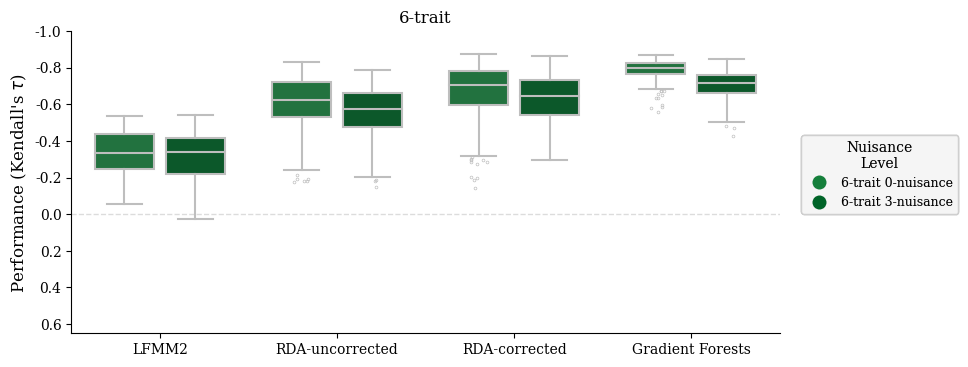

In [27]:
g = sns.catplot(
    data=validation,
    y='score',
    x='program',
    order=mvp.hue_order['program'][2:],
    hue='nuis_envs',
    hue_order=['6-trait 0-nuisance', '6-trait 3-nuisance'],
    kind='box',
    legend=False,
    **mvp.boxplot_kwargs
)

g.figure.set_size_inches(8, 4)

cleanup_fig(g, bbox_to_anchor=(1, 0.55), color_by='6-trait', fontsize=9, title='6-trait')

g.set(xlabel=None)

# adjust_box_widths(list(g.axes[0]), 0.85)

# g.set_axis_labels(None, "Performance (Kendall's $\\tau$)", fontsize=12)

# g.set(title='6-trait')

# mvp.jitter_fliers(g)

# for ax in g.axes.flat:
#     ax.set_ylim(0.65, -1)
# #     ax.invert_yaxis()
#     ax.axhline(0, linestyle='--', color='gainsboro', linewidth=1, zorder=0)

#     mvp.update_ticklabels(ax)
    
#     ax.set_xlabel(None)
    
mvp.add_legend(g.figure, color_by='6-trait', loc='center left', bbox_to_anchor=(1, 0.55), fontsize=9)
    
save_pdf(f'{fig_dir}/6-trait_program_by_nuisance-level.pdf')

In [11]:
formatclock(dt.now() - t0)

'0-00:00:01'